# Visual Exploration of NSW Crime Statistics
Let's examine some NSW Crime Statistics data and see what we can learn. There's two decent sources of data, both from NSW Government: 
https://data.gov.au/dataset/nsw-crime-data

https://data.nsw.gov.au/data/dataset/non-domestic-assaults-sydney-lga/resource/8fa12ba1-bfba-42d5-bfc7-037604b75b7c?inner_span=True

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [31]:
path = "F:/Datasets/RCI_offencebymonth/RCI_offencebymonth.csv"
df = pd.read_csv(path)
df.info()
df = pd.melt(df, id_vars = ["LGA", "Offence category", "Subcategory"], var_name = "Date", value_name = "Value")
df = df[(df.Value != 0)]
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9610 entries, 0 to 9609
Columns: 255 entries, LGA to 01-12-15
dtypes: int64(252), object(3)
memory usage: 18.7+ MB


,LGA,Offence category,Subcategory,Date,Value
4,Albury,Assault,Domestic violence related assault,01-01-95,7
5,Albury,Assault,Non-domestic violence related assault,01-01-95,29
6,Albury,Assault,Assault Police,01-01-95,12
7,Albury,Sexual offences,Sexual assault,01-01-95,4
8,Albury,Sexual offences,"Indecent assault, act of indecency and other s...",01-01-95,3


In [33]:
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
month_map = {1: "Jan", 2: "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
             7: "Jul", 8 : "Aug", 9 : "Sep", 10: "Oct", 11 : "Nov", 12: "Dec"}
df["Month"].replace(month_map, inplace = True)


## Plotting!
Given our above manipulations, we now have the data in a format which permits quite easy plotting.

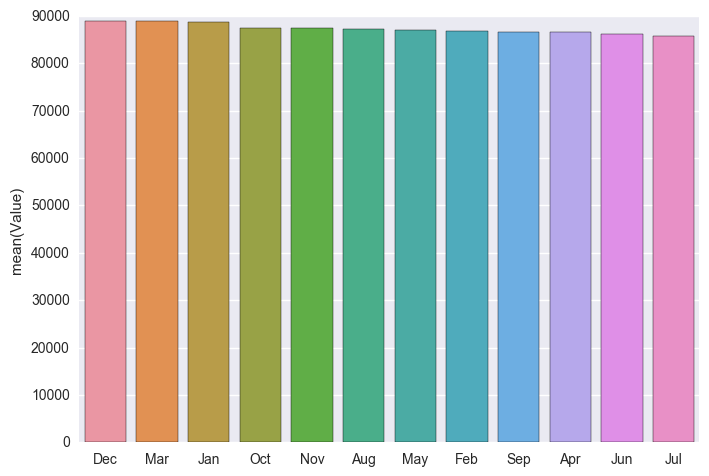

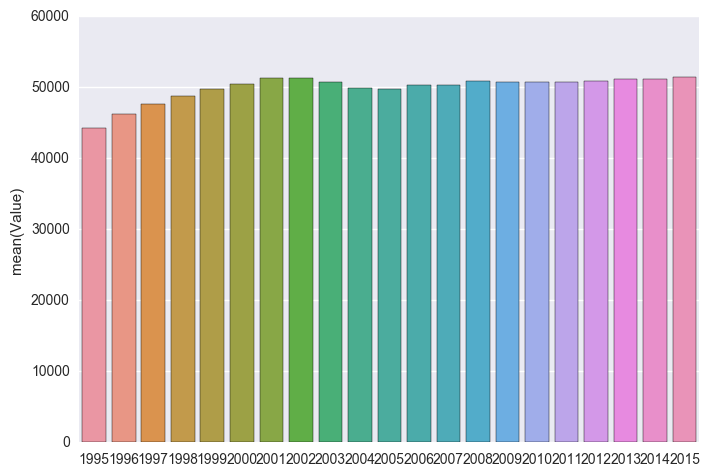

In [63]:
region = pd.DataFrame(df["LGA"].value_counts())
yearly = pd.DataFrame({"Value": df["Year"].value_counts()})
monthly = pd.DataFrame({"Value": df["Month"].value_counts()})
sns.barplot(x = monthly.index, y = "Value", data = monthly)
plt.show()

sns.barplot(x = yearly.index, y = "Value", data = yearly)
plt.show()

From the above we see that there's been a very slight upwards trend in Crime since 1995, but since 2002 it has flattened out. We also see that there is possibly a trend towards more crime in the December time of the year, perhaps to do when more people are out celebrating for Christmas and New Years?

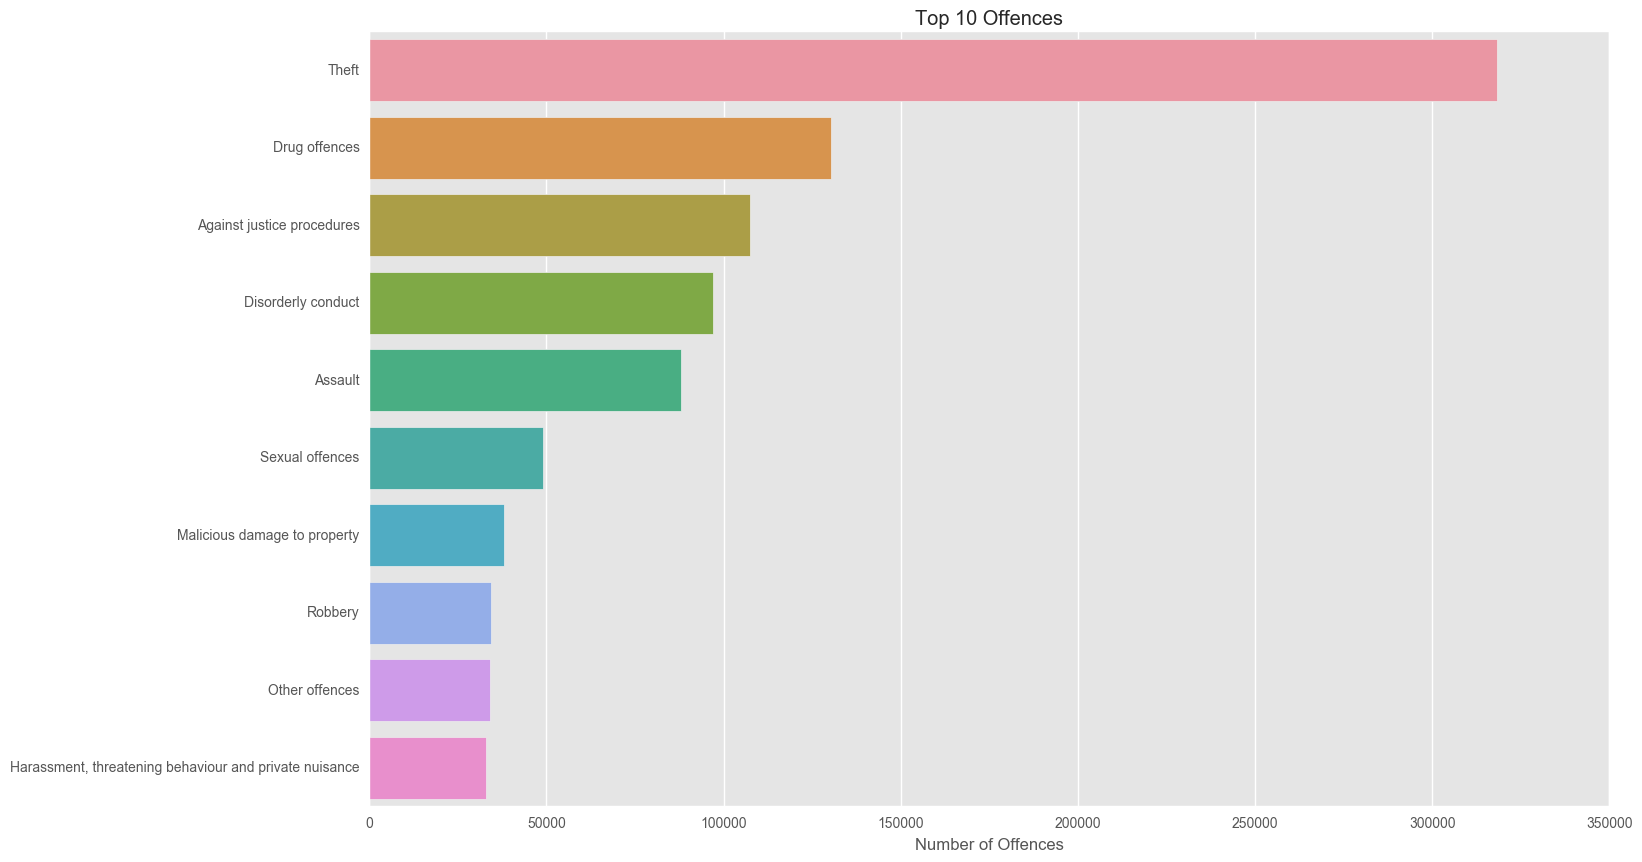

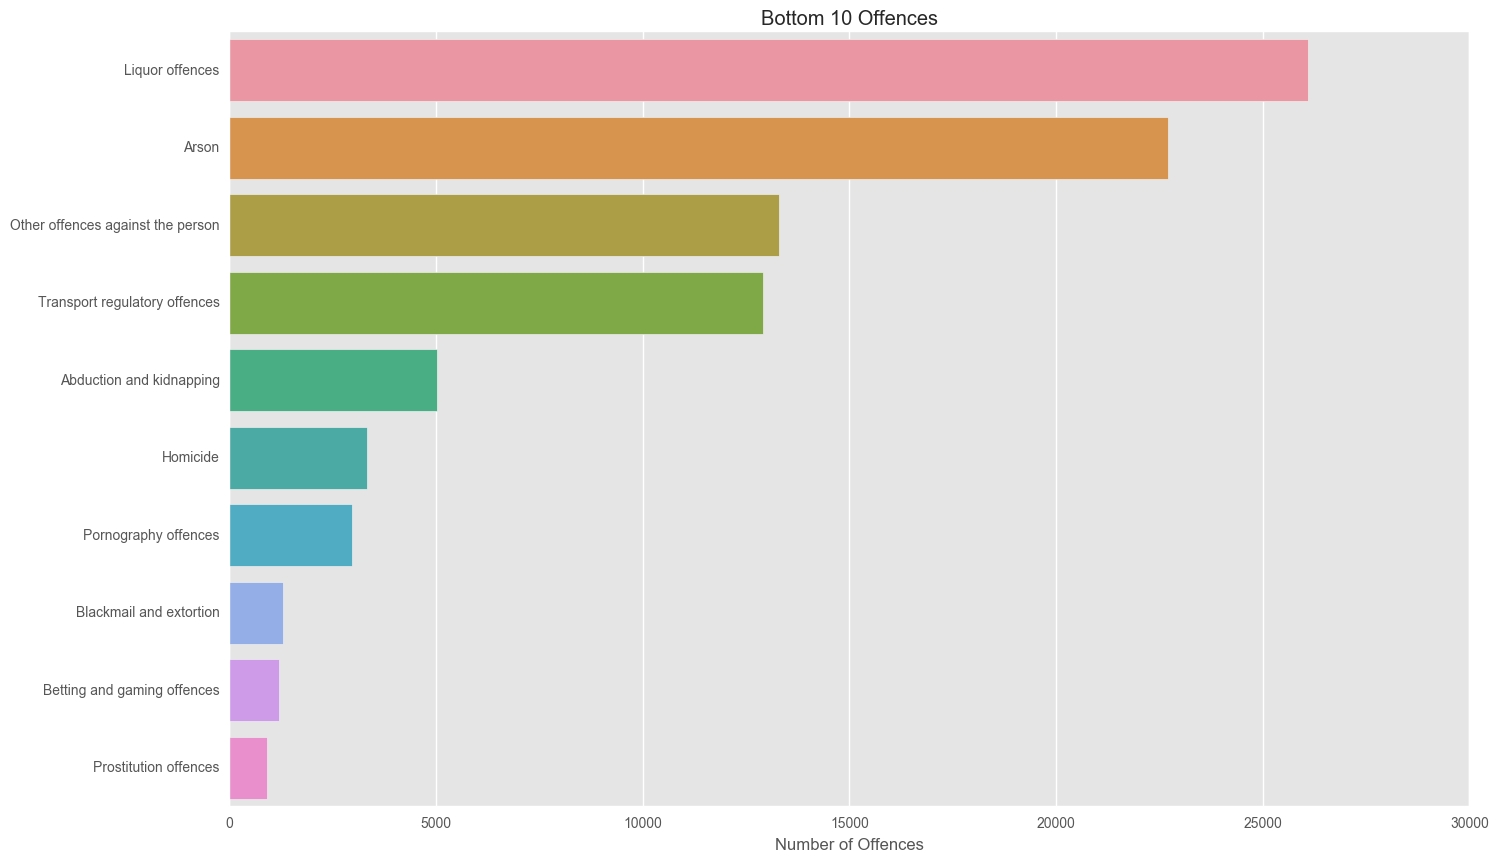

In [143]:
temp_df = pd.DataFrame(df.groupby(["Year", "Month", "LGA"]).size(), columns = ['count'])
temp_df.reset_index(inplace=True)
cr_counts = pd.DataFrame(df["Offence category"].value_counts())

plt.figure(figsize = (16,10))
sns.barplot(y=cr_counts.head(10).index, x = 'Offence category', data = cr_counts.head(10), orient = "h")
plt.title("Top 10 Offences")
plt.xlabel("Number of Offences")
plt.show()

plt.figure(figsize = (16,10))
sns.barplot(y=cr_counts.tail(10).index, x = 'Offence category', data = cr_counts.tail(10), orient = "h")
plt.title("Bottom 10 Offences")
plt.xlabel("Number of Offences")
plt.show()

We see that overall theft and drug offences are the most common over our time period of 1995-2015. Let's now look at the trends in these crime rates over time.

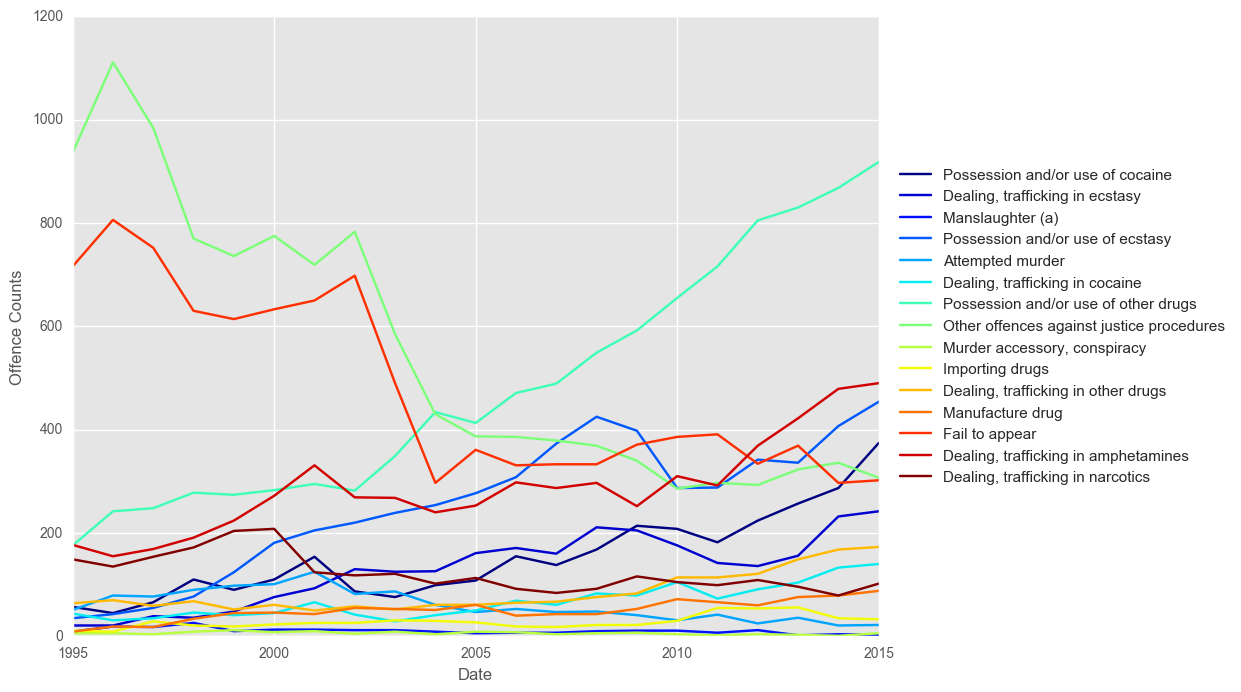

In [149]:
def plotTimeGroup(df_cat, ncols = 10, area = False, title = None):
    cov = pd.DataFrame(columns=["Category", "CV"])
    rows = []
    
    for column in df_cat.columns:
        col = df_cat[column]
        
        rows.append({"Category":column, "CV": col.std()/col.mean()})
    
    cov = pd.DataFrame(rows).sort_values(by="CV", ascending = 0)
    topCov = cov[:ncols]["Category"].tolist()
    
    f = plt.figure(figsize = (13,8))
    ax = f.gca()
    if area:
        df_cat[topCov].plot.area(ax=ax, title=title, colormap="jet")
    else:
        df_cat[topCov].plot(ax=ax, title=title, colormap="jet")
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), borderaxespad=1, fontsize=11)
    

#Plots by year
df_cat = df[["Date", "Subcategory"]]
df_cat = df_cat.groupby([df_cat["Date"].map(lambda x: x.year), "Subcategory"])
df_cat = df_cat.size().unstack()
plotTimeGroup(df_cat, ncols = 15)
plt.ylabel("Offence Counts")
plt.show()

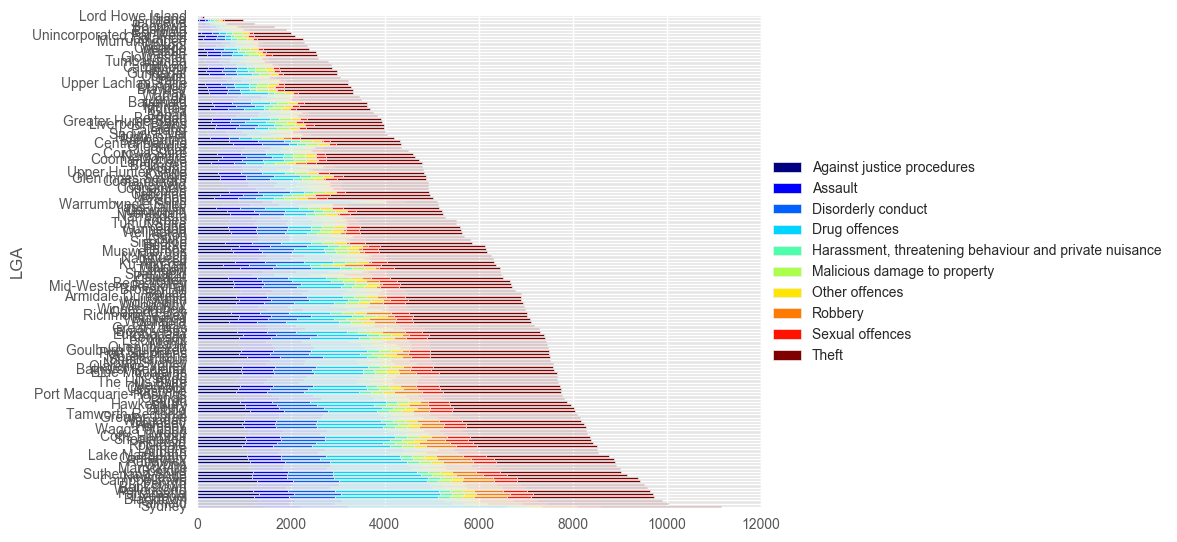

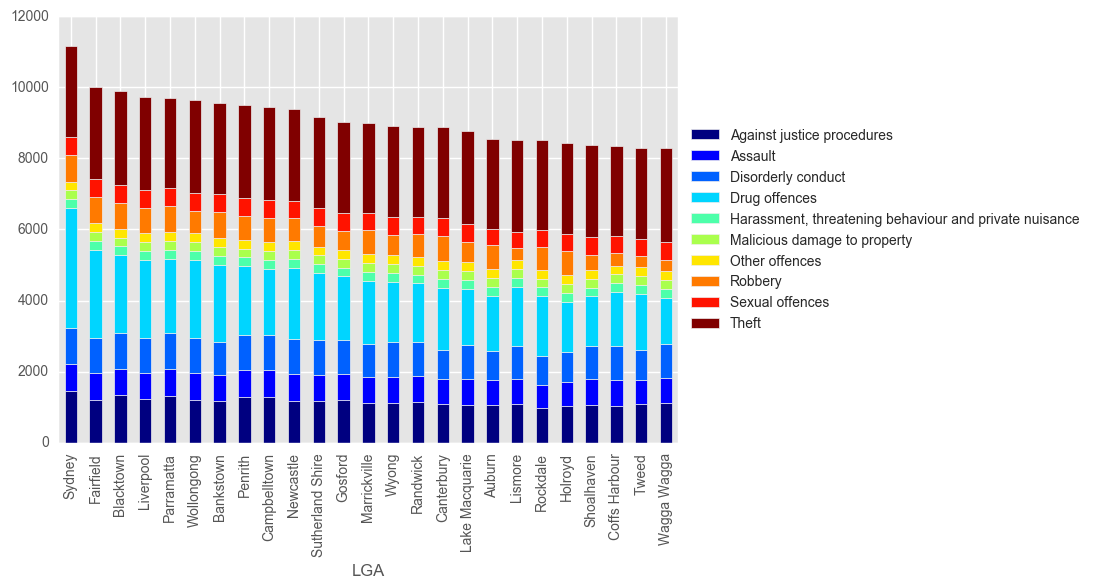

In [158]:
top10cc = pd.Series(cr_counts.head(10).index)
top10 = df[df['Offence category'].isin(top10cc)]
tmp2 = pd.DataFrame(top10.groupby(['LGA','Offence category']).size(), columns = ['count'])
tmp2.reset_index(inplace=True)
tmp2 = tmp2.pivot(index='LGA', columns = 'Offence category', values = 'count')
tmp2["total"] = tmp2.sum(axis=1)
tmp2 = tmp2.sort_values(by = "total", ascending = False)

del tmp2["total"]

tmp2.plot(kind = 'barh', stacked = True, colormap="jet")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

tmp2[0:25].plot(kind='bar', stacked = True, colormap="jet")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Sydney Specific Crime!
Now we can dive a bit deeper into our chosen local Government area of Sydney.

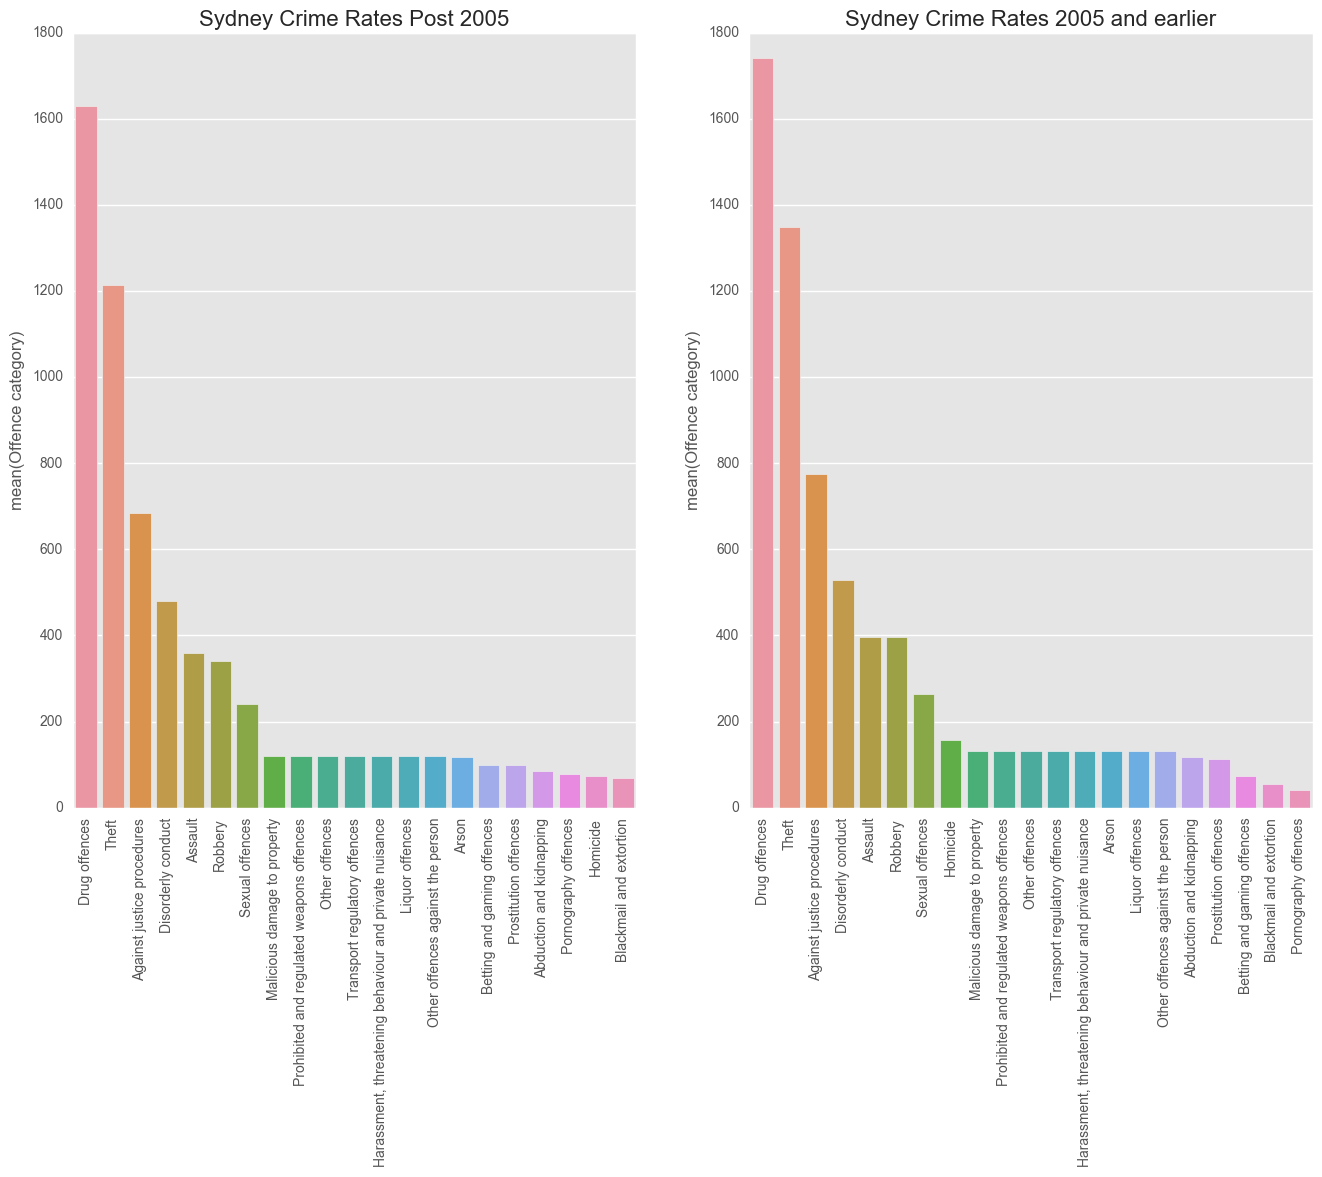

In [135]:
test_syd_new =df[(df.LGA == 'Sydney') & (df.Year > 2005)]
test_syd_old = df[(df.LGA == 'Sydney') & (df.Year <= 2005)]

syd_cr_new = pd.DataFrame(test_syd_new["Offence category"].value_counts())
syd_cr_old = pd.DataFrame(test_syd_old["Offence category"].value_counts())

plt.figure(figsize = (16,10))
ax1 = plt.subplot2grid((1,2), (0,0))
ax1.set_xticklabels(ax1.xaxis.get_ticklabels(), rotation = 90)
ax1.set_title("Sydney Crime Rates Post 2005", size = 16)
sns.barplot(x=syd_cr_new.index, y = 'Offence category', data = syd_cr_new)
ax2 = plt.subplot2grid((1,2),(0,1))
sns.barplot(x=syd_cr_old.index, y = 'Offence category', data = syd_cr_old)
ax2.set_xticklabels(ax2.xaxis.get_ticklabels(), rotation = 90)
ax2.set_title("Sydney Crime Rates 2005 and earlier", size = 16)
plt.show()


Let's do some exploration on the crimes with the highest coefficient of variations.

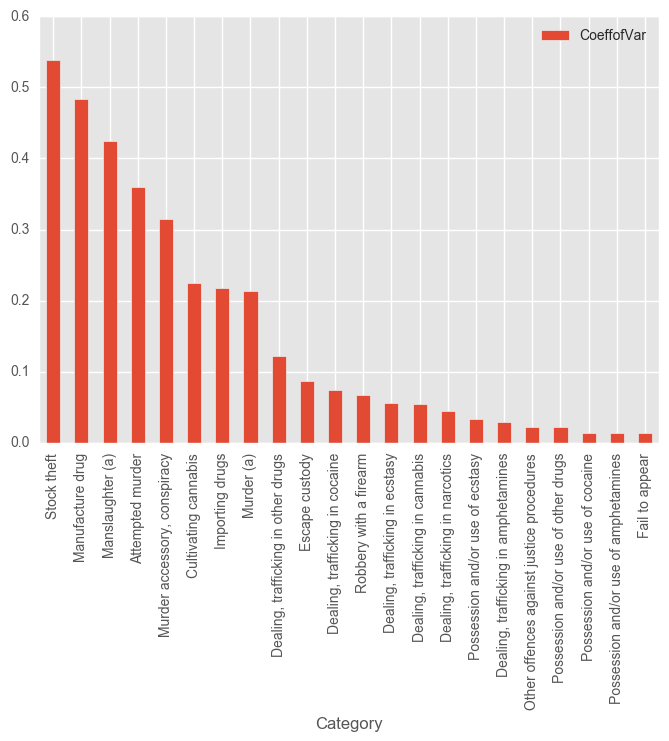

In [142]:
dayofweeksvars = pd.DataFrame(columns = ['Category', 'CoeffofVar'])
rows = []
for c in test_syd['Subcategory'].unique():
    dfSubset = test_syd[test_syd['Subcategory'] == c]
    dfSubsetGrouped = dfSubset.groupby("Month")["Subcategory"].count()
    std = dfSubsetGrouped.std()
    mean = dfSubsetGrouped.mean()
    cv = std / mean
    rows.append({'Category': c, 'CoeffofVar': cv})

categoryDayCV = pd.DataFrame(rows).sort_values(by = "CoeffofVar", ascending = 0)
categoryDayCV.head()
categoryDayCV[categoryDayCV.CoeffofVar >0].plot(x="Category", kind = "bar")
plt.show()

Given the above information, we might now want to look at the monthly trends in the above crimes, given their large variation.

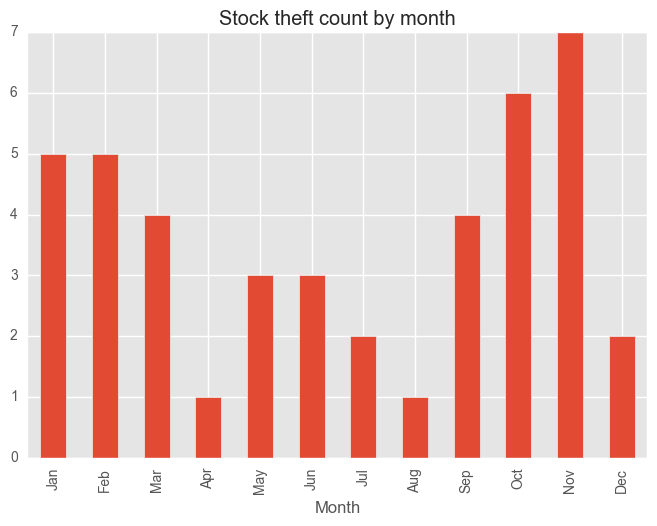

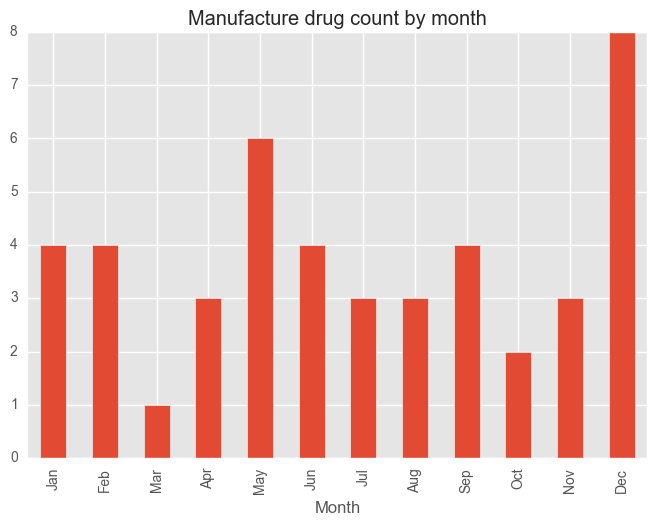

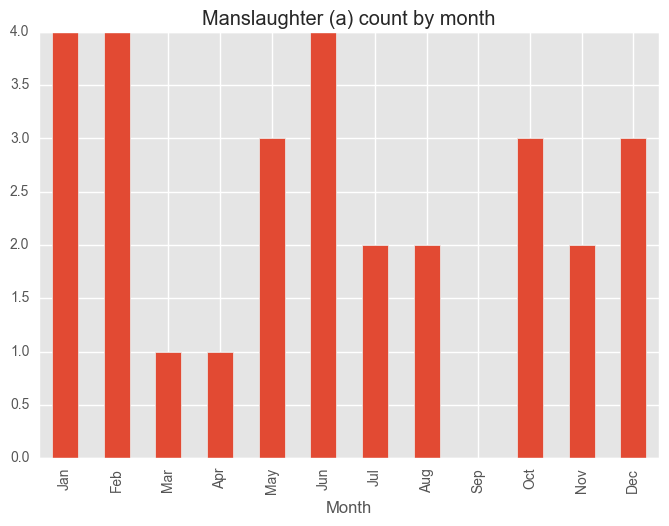

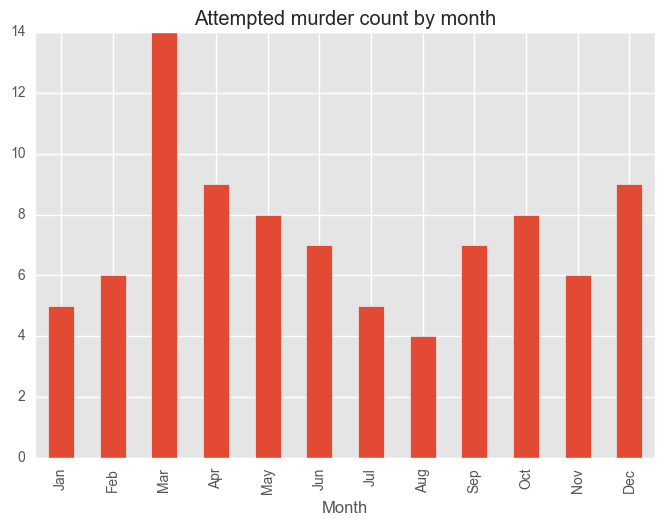

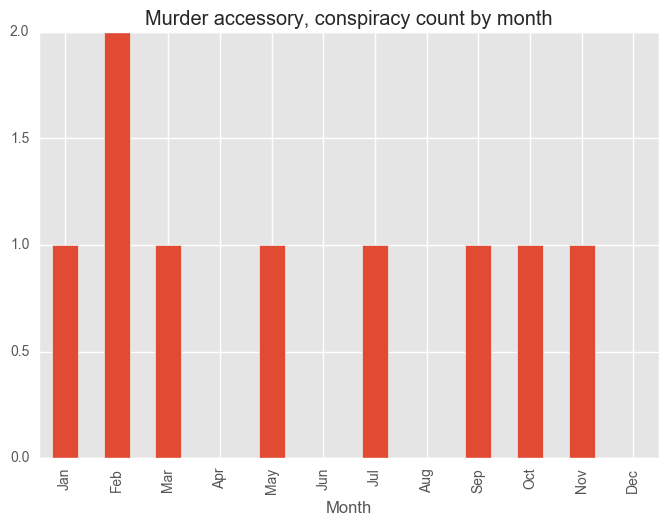

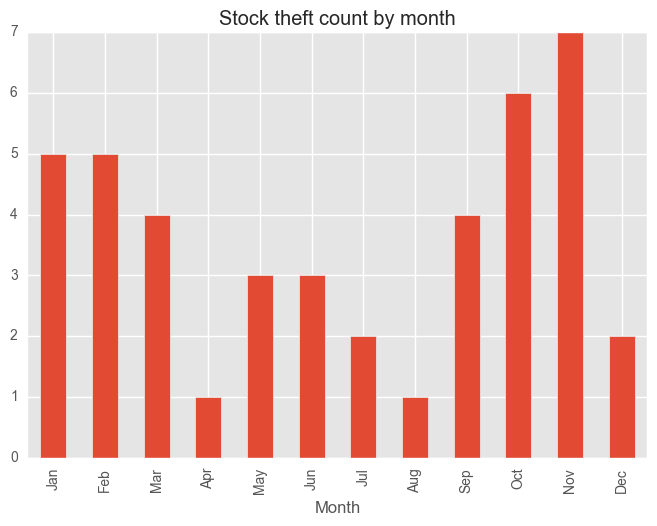

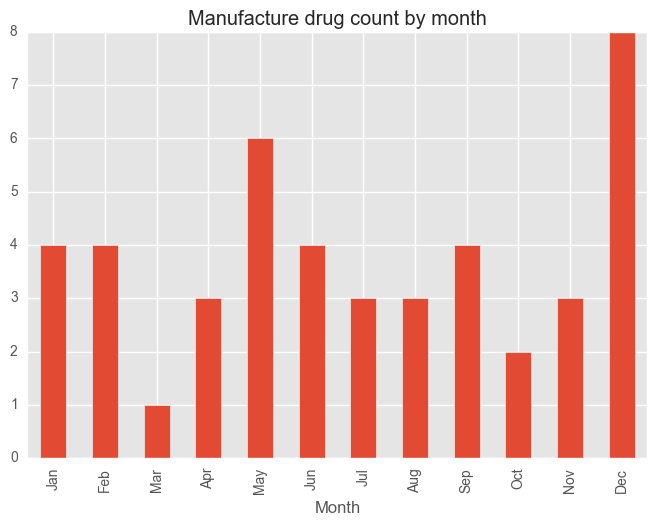

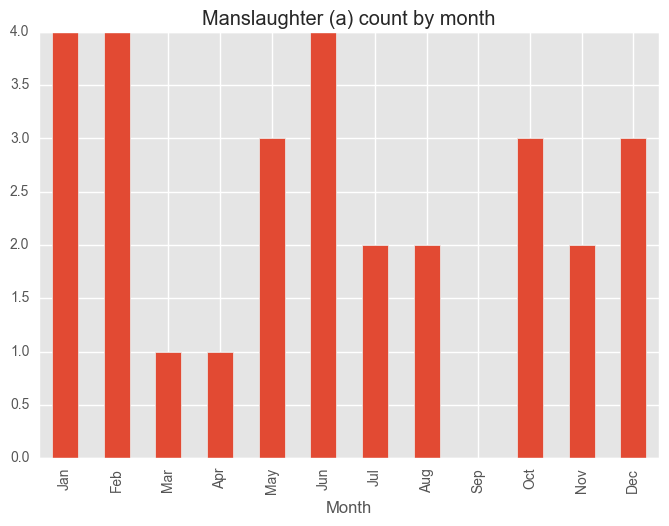

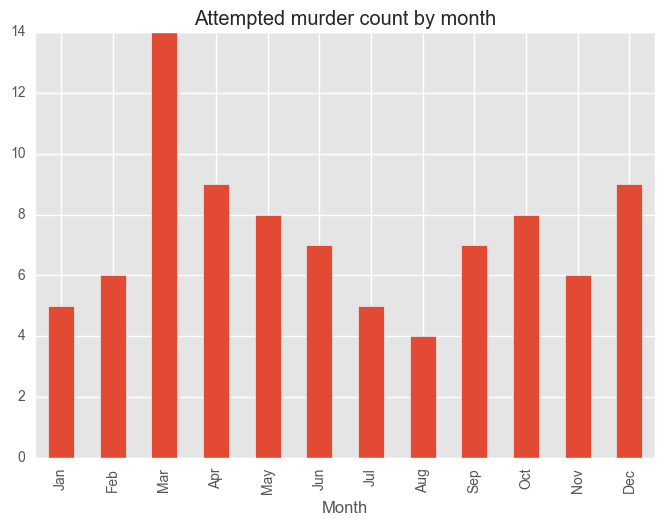

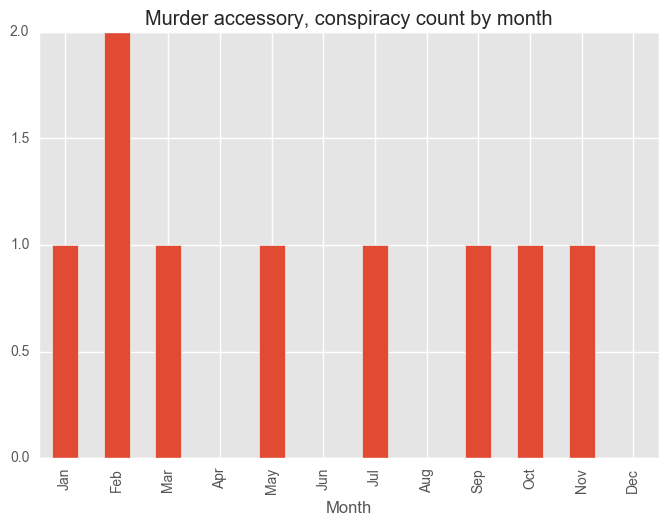

In [128]:
for category in categoryDayCV["Category"][:5]:
    dfCategory = test_syd[test_syd["Subcategory"] == category]
    groups = dfCategory.groupby("Month")["Subcategory"].count()
    months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
    groups = groups[months]
    plt.figure()
    groups.plot(kind="bar", title = category + " count by month")
    
plt.show()

## Dataset 2
We'll now look at a dataset with some more granular level information on committed crimes in the Sydney LGA.

In [172]:
url_2 = "F:/Datasets/RCI_offencebymonth/NSW2016-Dataset-Selected-outdoor-crimes-in-Sydney-LGA.csv"
df_syd = pd.read_csv(url_2)

day_map = {'Monday': 1,
          'Tuesday': 2,
          'Wednesday': 3,
          'Thursday': 4,
          'Friday': 5,
          'Saturday': 6,
          'Sunday': 7}

month_map = {'January': 1,
             'February': 2,
             'March': 3,
             'April': 4,
             'May': 5,
             'June': 6,
             'July': 7,
             'August': 8,
             'September': 9,
             'October': 10,
             'November': 11,
             'December': 12}

def time_to_hour(time):
    time = time.split(':')
    x = time[0]
    y = time[1]
    x = int(x)
    y = int(y)
    
    if y > 30: 
        x += 1
        
    return x

# Apply adjustments to month, day and time of day
df_syd['incmonth'] = df_syd["incmonth"].map(month_map)
df_syd['incday'] = df_syd["incday"].map(day_map)
df_syd['incsttm'] = df_syd["incsttm"].apply(lambda x: time_to_hour(x))

df_syd.head()


,FID,OBJECTID,bcsrgrp,bcsrcat,lganame,locsurb,locprmc1,locpcode,bcsrgclat,bcsrgclng,bcsrgccde,incyear,incmonth,incday,incsttm,eventyr,eventmth,poisex,poi_age,uniqueID
0,0,1,Assault,Non-domestic violence related assault,Sydney,REDFERN,OUTDOOR/PUBLIC PLACE,2016,-33.892390,151.214790,Intersect,2012,8,1,16,2013,February,,0.000000,50658277
1,1,2,Assault,Non-domestic violence related assault,Sydney,SYDNEY,OUTDOOR/PUBLIC PLACE,2000,-33.867700,151.209840,Intersect,2012,10,2,18,2013,February,,0.000000,53061821
2,2,3,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.872671,151.219100,Address,2013,1,2,1,2013,January,,0.000000,50001248
3,3,5,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.870260,151.220190,Intersect,2013,1,2,3,2013,January,,0.000000,49962948
4,4,6,Assault,Non-domestic violence related assault,Sydney,SURRY HILLS,OUTDOOR/PUBLIC PLACE,2010,-33.880070,151.215001,Intersect,2013,1,2,13,2013,January,M,50.331964,49970181


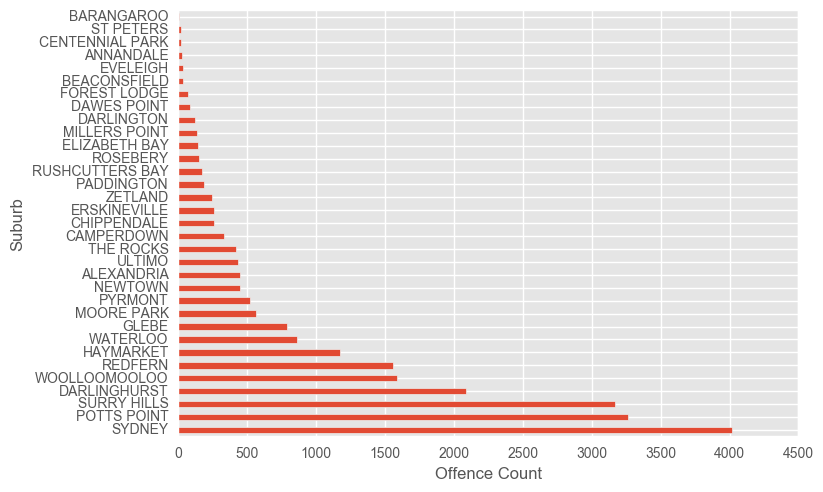

In [157]:
df_syd.groupby(["locsurb"]).count()["FID"].sort_values(ascending=False).plot(kind="barh")
plt.ylabel("Suburb")
plt.xlabel("Offence Count")
plt.show()

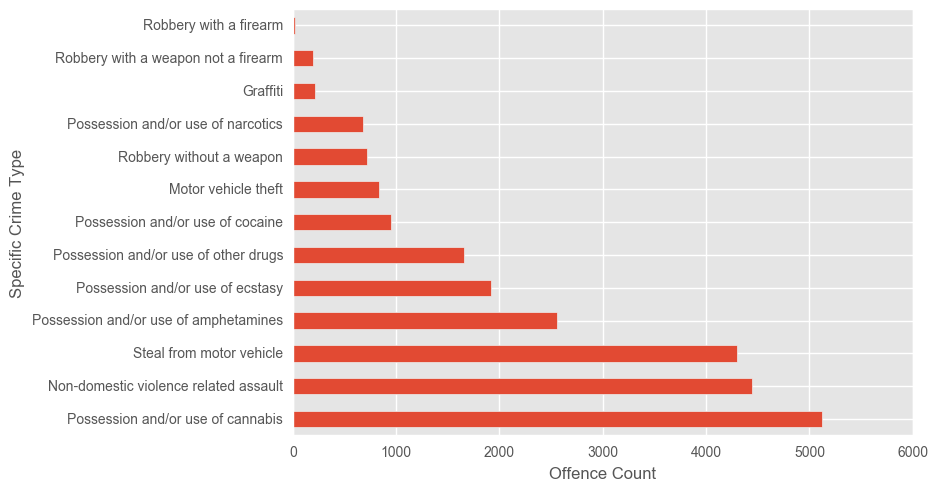

In [180]:
df_syd.groupby(["bcsrcat"]).count()["FID"].sort_values(ascending=False).plot(kind="barh")
plt.ylabel("Specific Crime Type")
plt.xlabel("Offence Count")
plt.show()

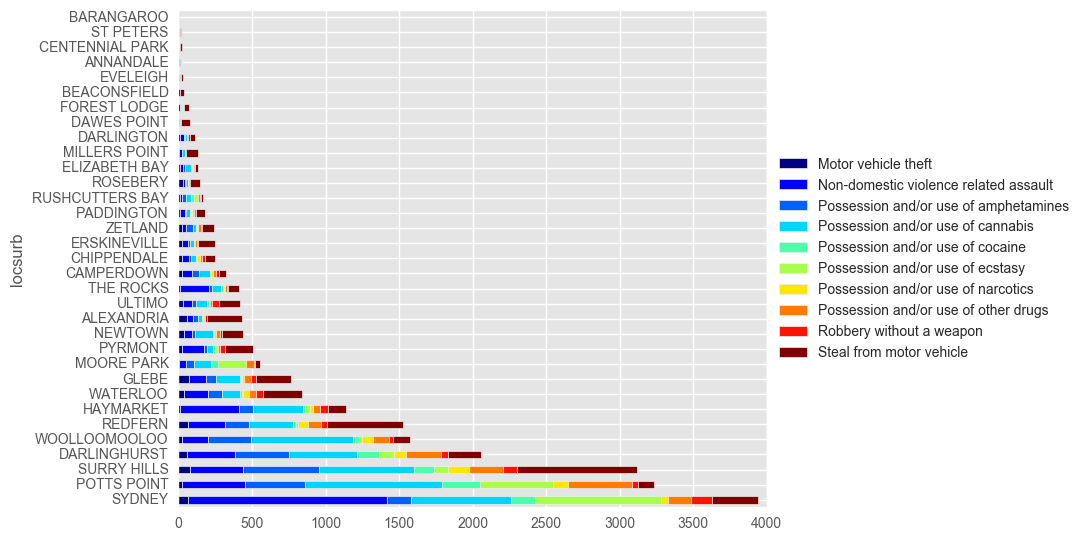

In [179]:
syd_counts = pd.DataFrame(df_syd["bcsrcat"].value_counts())
top10cc = pd.Series(syd_counts.head(10).index)
top10 = df_syd[df_syd['bcsrcat'].isin(top10cc)]
tmp2 = pd.DataFrame(top10.groupby(['locsurb','bcsrcat']).size(), columns = ['count'])
tmp2.reset_index(inplace=True)
tmp2 = tmp2.pivot(index='locsurb', columns = 'bcsrcat', values = 'count')
tmp2["total"] = tmp2.sum(axis=1)
tmp2 = tmp2.sort_values(by = "total", ascending = False)

del tmp2["total"]

tmp2.plot(kind = 'barh', stacked = True, colormap="jet")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

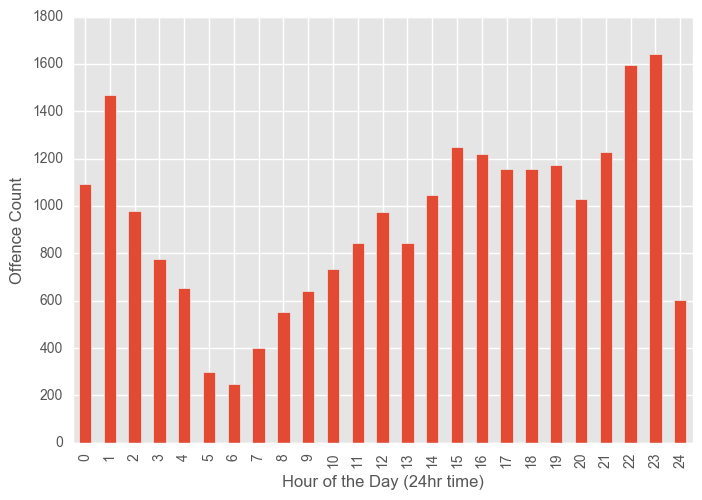

In [169]:
df_syd.groupby(["incsttm"]).count()["FID"].plot(kind="bar")
plt.xlabel("Hour of the Day (24hr time)")
plt.ylabel("Offence Count")
plt.show()

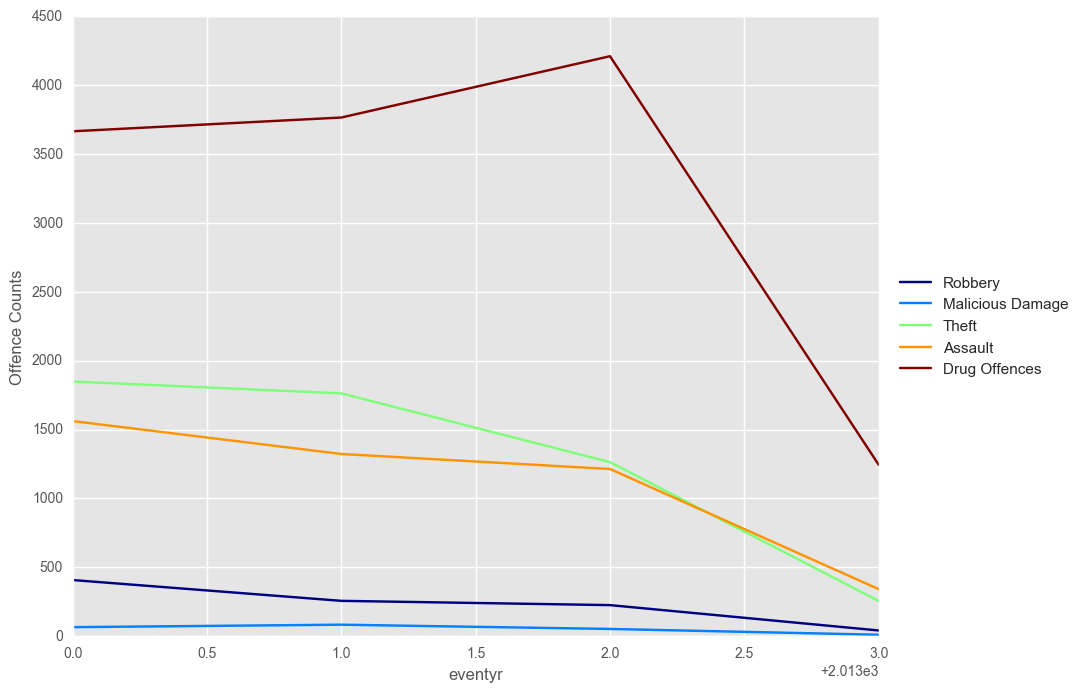

In [175]:
df_cat2 = df_syd[["eventyr", "bcsrgrp"]]
df_cat2 = df_cat2.groupby([df_cat2["eventyr"], "bcsrgrp"])
df_cat2 = df_cat2.size().unstack()
plotTimeGroup(df_cat2, ncols = 15)
plt.ylabel("Offence Counts")
plt.show()

## Visual Mapping Attempt
With little to no experience plotting on maps, this shall be interesting. We'll look to plot lat/lon coordinates for each incident, and then see if we can produce a heatmap out of it. 

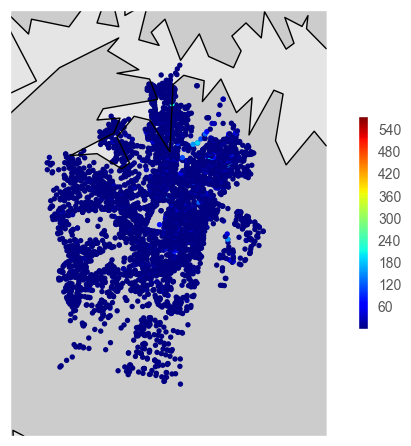

In [368]:
from mpl_toolkits.basemap import Basemap
m = Basemap(projection='merc',
    resolution = 'h' ,llcrnrlon=151.165, llcrnrlat=-33.935,
              urcrnrlon=151.25,urcrnrlat=-33.84)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(zorder=0)
jet = plt.cm.get_cmap('jet')

data = df_syd.groupby(["bcsrgclat", "bcsrgclng"]).count()
vals = data.index.get_values()
x = [x for x,y in vals]
y = [y for x,y in vals]
count = data["FID"]
count = count.reset_index()["FID"]

y,x = m(y,x)

#m.plot(y,x, 'bo', markersize =1)

sc = plt.scatter(y,x, c = count, vmin = 1, vmax = 580, cmap = jet, s = 15, edgecolors = 'none')
cbar = plt.colorbar(sc, shrink = .5)
plt.show()

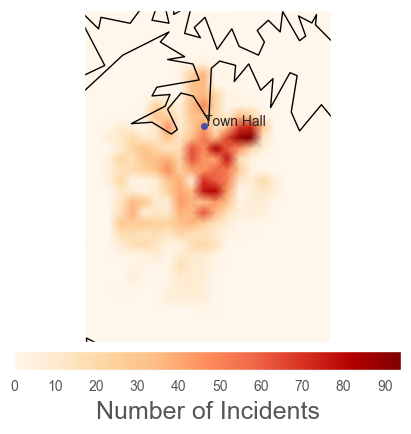

In [411]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap

m = Basemap(projection='merc',
    resolution = 'h' ,llcrnrlon=151.165, llcrnrlat=-33.935,
              urcrnrlon=151.25,urcrnrlat=-33.84)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(zorder=0)
jet = plt.cm.get_cmap('jet')

data = df_syd.groupby(["bcsrgclat", "bcsrgclng"]).count()
vals = data.index.get_values()
x = [x for x,y in vals]
y = [y for x,y in vals]


lon_bins = np.linspace(151.1, 151.3, 50) # Pull these based on min/max in data
lat_bins = np.linspace(-33.95, -33.80, 50) # Pull these based on min/max in data
density, lat_edges, lon_edges = np.histogram2d(x, y, [lat_bins, lon_bins])
lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins)

xs, ys = m(lon_bins_2d, lat_bins_2d) 

plt.register_cmap(cmap=custom_map)
density = np.hstack((density,np.zeros((density.shape[0],1))))
density = np.vstack((density,np.zeros((density.shape[1]))))

plt.pcolormesh(xs, ys, density, cmap=plt.cm.get_cmap('OrRd'), shading='gouraud')
cbar = plt.colorbar(orientation='horizontal', shrink=0.625, aspect=20, fraction=0.2,pad=0.02)
cbar.set_label('Number of Incidents',size=18)

x,y = m(151.206088, -33.873144) # Lookup locations on google
m.plot(x, y, 'o', markersize=5,zorder=6, markerfacecolor='#424FA4',markeredgecolor="none")
plt.text(x, y, "Town Hall")
plt.show()
